In [4]:
import numpy as np
import os,sys,math, copy, pickle
from scipy.spatial import distance
from random import seed,random,randint
import pandas as pd
import matplotlib.pyplot as plt
#install lib
!pip install DeCida
from decida.Pattern import Pattern
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['figure.figsize'] = [16, 8]
import statsmodels.api as sm
import statsmodels.tsa as tsa
from scipy import signal
from scipy.fftpack import fft, fftfreq
import tmsd_codes as tmsd #PRBS, Auto and cross-correlation

seed(1234)
np.random.seed(1234)

distributed 1.21.8 requires msgpack, which is not installed.
tensorflow 1.11.0 has requirement setuptools<=39.1.0, but you'll have setuptools 45.2.0 which is incompatible.
jupyterthemes 0.20.0 has requirement notebook>=5.6.0, but you'll have notebook 5.5.0 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### 1 - Gerar PRBS e Analisar a autocorrelação
- Pode-se ver que a relação entre o sinal só é alta no valor 0, para outros valores, o valor está abaixo do nível de confiança. Significa dizer que o sinal gerado realmente tem características aleatórias.

1024


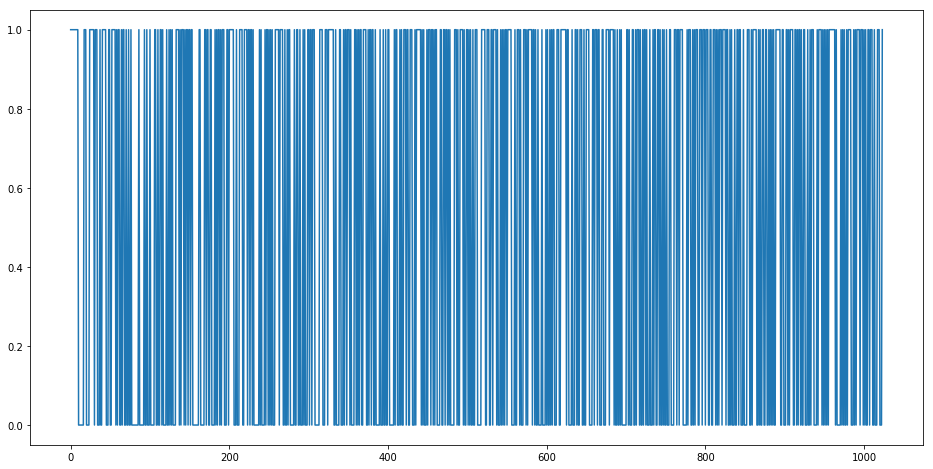

In [5]:
p = Pattern(v0=0,v1=1, delay=1, edge=1, period= 1, format = 'binary')
prbs = p.prbs(size = 10,length=1024)
prbs = [int(i) for i in prbs]
print(len(prbs))
plt.plot(prbs)

prbs = [int(i)+2 for i in prbs]

#### Autocorrelação

- Apresenta o comportamento esperado. A correlação é total, valor 1 utilizando normalização, quando não há deslocamento. Para os outros casos o valor é muito baixo. 

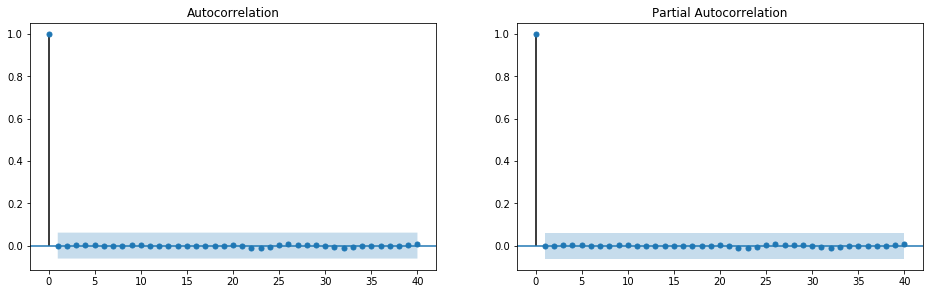

In [6]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(prbs, lags=40, ax=ax1)
ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(prbs, lags=40, ax=ax2)

#### 2 - Questão

- Utilizando a entrada no sistema com o erro de 0.05 e calculando a correlação cruzada.

In [7]:
#função que implementa as equações diferenciais referente ao modelo do tanque quádruplo
def dvTanQua(x, uv1, uv2, t):
    A1,A2,A3,A4 = 32,28,32,28 #cm²
    alpha1,alpha2,alpha3,alpha4 = 0.071,0.071,0.071,0.071
    g = 981#cm²s⁻²
    k1, k2, kc = 3.33,3.33,0.5
    y1,y2 = 0.6, 0.7 #verificar esses valores
    xd = []
    #equação 1
    xd_0 = (-alpha1/A1) * np.sqrt(2*g*x[0]) + (alpha3/A1)*np.sqrt(2*g*x[2]) + ((y1*k1)/A1)*uv1
    xd.append(xd_0*kc)
    #equação 2
    xd_1 = (-alpha2/A2) * np.sqrt(2*g*x[1]) + (alpha4/A2)*np.sqrt(2*g*x[3]) + ((y2*k2)/A2)*uv2
    xd.append(xd_1*kc)
    #Equação 3
    xd_2 = (-alpha3/A3) * np.sqrt(2*g*x[2]) + (((1 - y2)*k2)/A3)*uv2
    xd.append(xd_2)
    #Equação 4
    xd_3 = (-alpha4/A4) * np.sqrt(2*g*x[3]) + (((1 - y1)*k1)/A4)*uv1
    xd.append(xd_3)

    return xd


#Função que implementa o Runge–Kutta de quarta ordem 
def rkTanQua(x0, uv1, uv2, h, t):
    #1st evaluation
    xd = dvTanQua(x0, uv1, uv2, t)
    savex0 = x0.copy()
    phi = xd.copy()
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    #2nd evaluation
    xd = dvTanQua(x0, uv1, uv2, t + 0.5 * h)
    phi = (phi + 2 * xd)
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    #3rd evaluation
    xd = dvTanQua(x0, uv1, uv2, t + 0.5 * h)
    phi = phi + 2 * xd
    for i in range(len(x0)):
        x0[i] = savex0[i] + h * xd[i]

    #4th evaluation
    xd = dvTanQua(x0, uv1, uv2, t + h)

    result_x = x0.copy()
    for i in range(len(x0)):
        result_x[i] = savex0[i] + (phi[i] + xd[i]) * h / 6

    return result_x



t0 = 0
tf = 5000
h = 1
t = np.arange(t0, tf, h)

#setando valores de pontos iniciais são necessários para execução em questão
init_ = [10.1]

#executando simulação 
x_f = []
for point_stt in init_:
    x0 = np.array([[point_stt], [point_stt], [point_stt], [point_stt]])

dc = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, dc, axis=1)
v = len(t) 

def dup(prbs, v=2):
    new_prbs = []
    for i in prbs:
        for j in range(v):
            new_prbs.append(i)
    return new_prbs

prbs = p.prbs(size = 10,length=100)
prbs = [int(i)+2 for i in prbs]

prbs = dup(prbs, v=20)

u = ([2]*(len(t)-len(prbs))) + prbs #signal_super(t,gains, b)
u = np.array(u)
print('dimensão da entrada: {}'.format(u.shape))
for k in range(1, len(t)):
    result = rkTanQua(x[:, k - 1], u[k], u[k], h, t[k])
    x[:, k] = result
print('Processamento Finalizado')

dimensão da entrada: (5000,)
Processamento Finalizado


#### Apresentação do sinal resultante (com ruído adicionado)

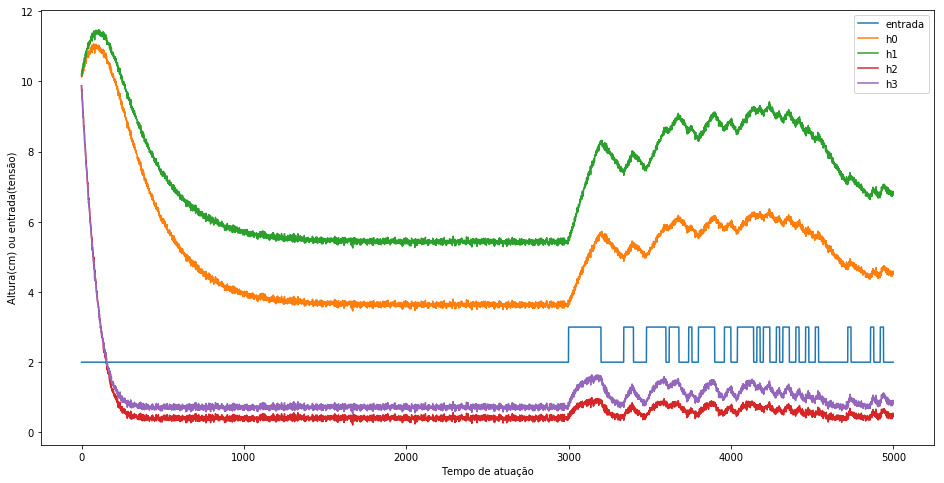

In [8]:
#função para plotar os resultados
def plotsignals(signals,ref,t, name_input,init_):
    l, = plt.plot(t,ref, label='entrada')
    for idx,sig in enumerate(signals):
        l, = plt.plot(t, sig, label='h'+str(idx))
        
    #plt.legend([name_input,'h1_sign_'+str(idx),'h2_sign_'+str(idx),'h3_sign_'+str(idx),'h4_sign_'+str(idx)], loc='lower right')
    plt.legend(loc='upper right')
    plt.xlabel('Tempo de atuação')
    plt.ylabel('Altura(cm) ou entrada(tensão)')
    plt.show()


noise = np.random.normal(0, .05, u.shape)
x[0] = x[0] + noise
x[1] = x[1] + noise
x[2] = x[2] + noise
x[3] = x[3] + noise
    
plotsignals(x,u,t, 'superposição',init_)


#### Tratamento do sinal

- Retirar valores repetidos do sinal, de forma a atender o método

In [11]:
def red_sampling(data, rate_reduc):
    number_samp = len(data)
    samples_slct = list(range(0,number_samp,rate_reduc))
    new_data = data[samples_slct]
    return new_data

##Cortar o sinal para o inicio do teste

n_u = u[3000:]
n_x = []
n_x.append(x[0][3000:])
n_x.append(x[1][3000:])
n_x.append(x[2][3000:])
n_x.append(x[3][3000:])

##reduzir valor para começar no 0
n_u = n_u - 2
n_x[0] = n_x[0] - n_x[0][0]
n_x[1] = n_x[1] - n_x[1][0]
n_x[2] = n_x[2] - n_x[2][0]
n_x[3] = n_x[3] - n_x[3][0]

##Diminuir o aumento do tempo de segurar o prbs
rate_reduc = 20
n_u = red_sampling(n_u, rate_reduc)
n_x[0] = red_sampling(n_x[0], rate_reduc)
n_x[1] = red_sampling(n_x[1], rate_reduc)
n_x[2] = red_sampling(n_x[2], rate_reduc)
n_x[3] = red_sampling(n_x[3], rate_reduc)


#### Plot Autocorrelação do sinal

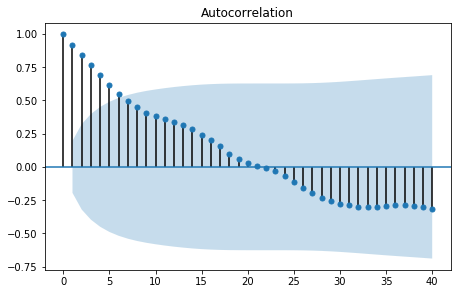

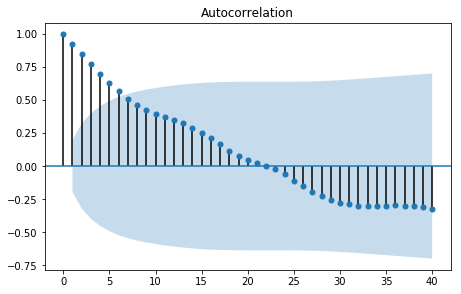

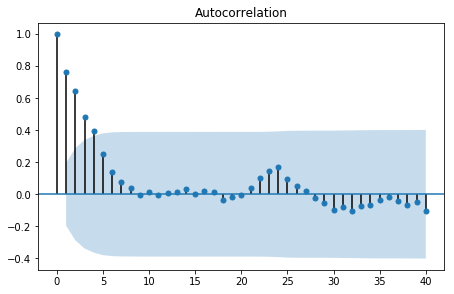

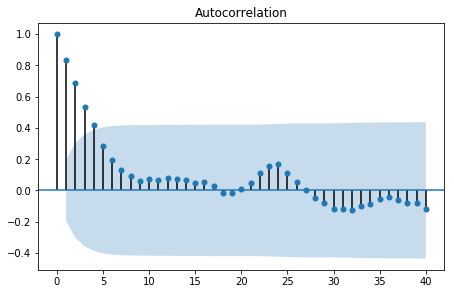

In [12]:
##COncertar limite de erro
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(n_x[0], lags=40, ax=ax1)

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(n_x[1], lags=40, ax=ax1)

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(n_x[2], lags=40, ax=ax1)

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(n_x[3], lags=40, ax=ax1)

#### 3 - Questão

- Estimar resposta ao impulso utilizando Wiener-Hopf 

In [13]:
def out_WH(y_, u_, tf):
    
    t_ry, ruy, l, Bruy = tmsd.myccf(y_,u_,41,0,1,legend = "cross-correlation")
    # Autocorrelação entrada PRBS
    t_ru, ru, l, Bru = tmsd.myccf(u_,u_,80,1,1,legend = "autocorrelation")

    # Estimando resposta ao impulso via Wiener-Hopf assumindo que a entrada eh perfeitamente 
    # aleatoria, ou seja, Ruu diagonal, eq. (4.14) do livro.
    u_var = np.var(u_,ddof =1)
    h = ruy/u_var # h = ruy/Bru
    #
    fig = plt.figure(figsize=(12, 4))
    p1, = plt.plot(h*Bruy, color = 'red', label = 'Wiener-Hopf, Ru diagonal')
    plt.xlabel('Lags')
    rur = ru[::-1]*Bru #ru tem simetria par
    index0 = int((len(rur)-1)/2)
    Ru = rur[index0:]
    for i in range(1,index0+1):
        newrow = rur[index0 - i:-i]
        Ru = np.vstack([Ru, newrow])

    Ru = np.matrix(Ru)
    ruy_v = np.matrix(ruy)
    Rui = np.linalg.inv(Ru)
    Hm = np.inner(Rui,ruy_v)
    p2, = plt.plot(t_ry,Hm, color = 'green', label = 'Wiener-Hopf, caso geral')

    lines = [p1,p2]
    plt.legend(lines, [l.get_label() for l in lines])
    Ru = np.matrix(Ru)
    
    t_imp, y_imp = signal.dimpulse(tf)
    y_imp = np.squeeze(y_imp)
    plt.stem(t_imp[0:40], y_imp[0:40], '-')

- Apesar de fazer a redução de taxa de amostragem, os valores que mais se aproximam são das duas saídas menores.

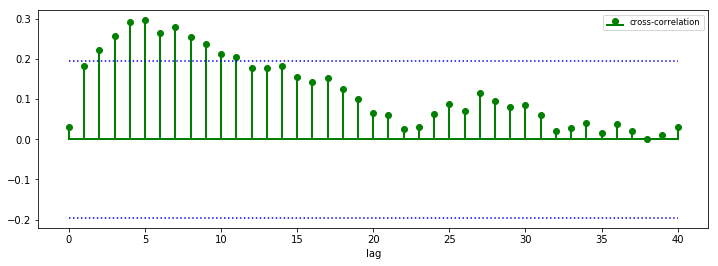

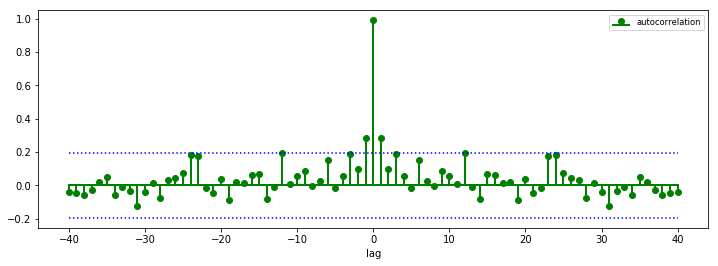

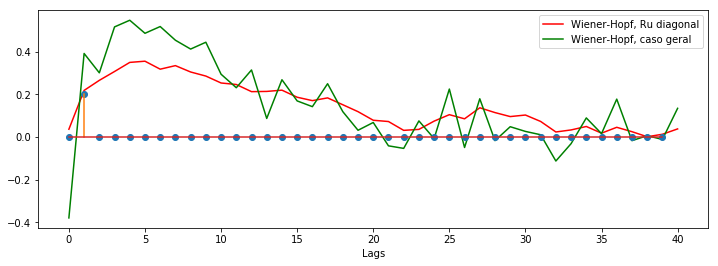

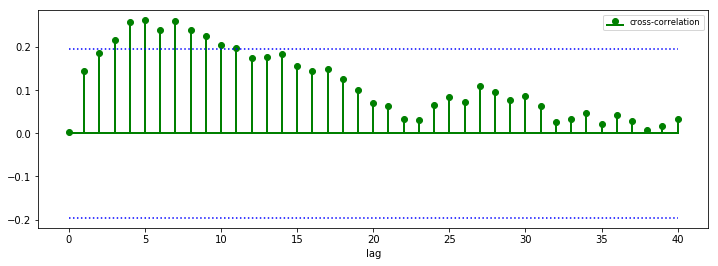

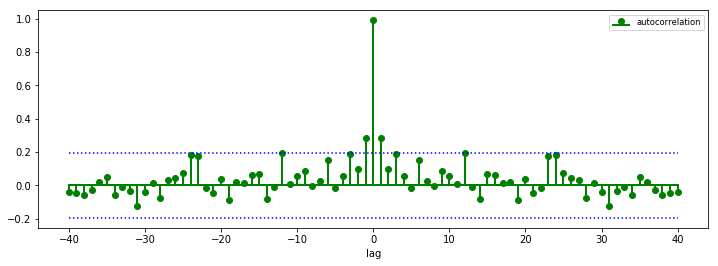

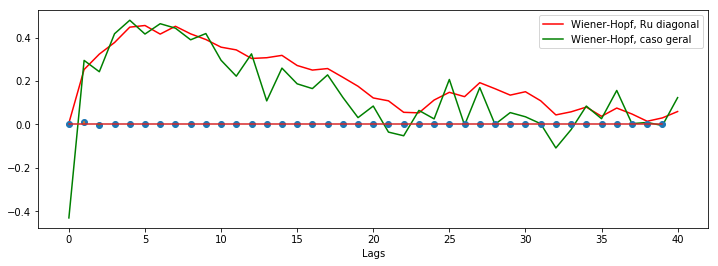

In [14]:
## plot sinal h1 e h2
num = [40]
den = [200, 1]
sist1 = signal.TransferFunction(num, den, dt=1)
num = [2.7]
den = [200, 1]
sist2 = signal.TransferFunction(num, den, dt=1)

out_WH(n_x[0], n_u, sist1)
out_WH(n_x[1], n_u, sist2)

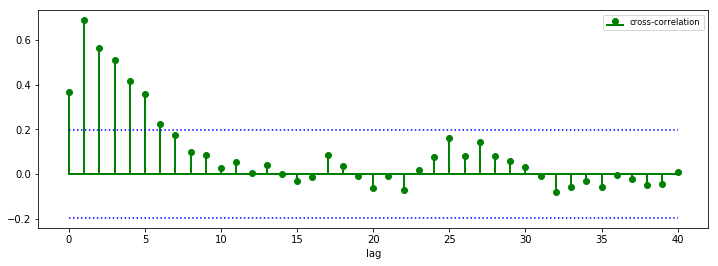

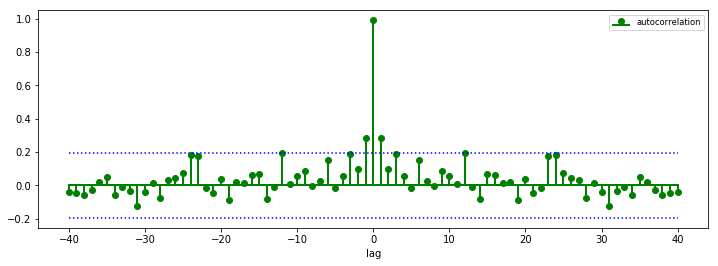

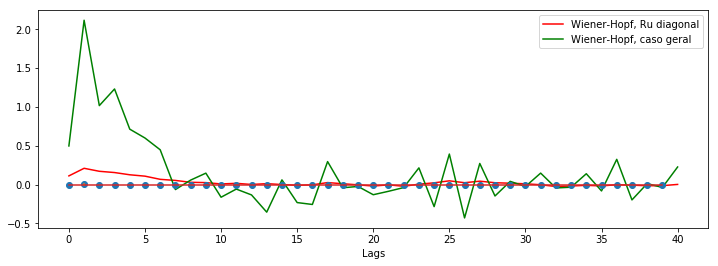

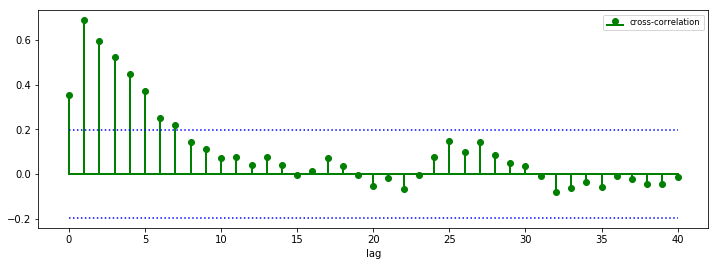

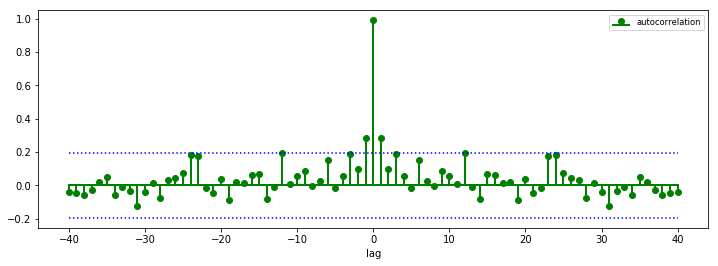

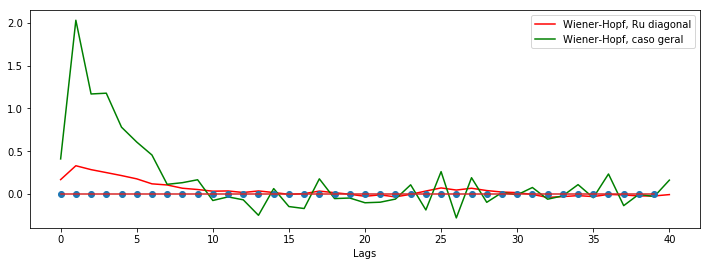

In [15]:
#Plot sinal h3 h4
num = [0.5]
den = [50, 1]
sist3 = signal.TransferFunction(num, den, dt=1)
num = [0.3]
den = [50, 1]
sist4 = signal.TransferFunction(num, den, dt=1)
out_WH(n_x[2], n_u, sist3)
out_WH(n_x[3], n_u, sist4)

#### 4 - Questão

- Apresenta a resposta em frequência

In [16]:
def freq(x_f, u, tf):
    y = x_f
    Y = fft(y)
    U = fft(u)
    H = Y/U

    freq = 1/len(y)*np.arange(0,len(y)/2)*2*math.pi

    # Bode estimado a partir das TF dos sinais de entrada e saída
    mag_db    = 20*np.log10(abs(H[:len(freq)]))
    phase_deg = np.angle(H[:len(freq)])*180/math.pi 

    # Bode a partir da função de transferência
    w, mag, phase = signal.dlti.bode(tf)

    # Plot: Bode da resposta em freq. estimada via FFT e da função de transferência
    fig, ax1 = plt.subplots(constrained_layout=True, figsize=(12, 4))    
    ax1.set_ylabel('$|H(j\omega)|_{db}$ ')
    ax1.set_xlabel('freq (rad/s)')
    plt.semilogx(freq,mag_db, color='green', label= 'Estimated via FTT')
    plt.semilogx(w, mag, color='red', label= 'Magnitude of the transfer function')
    plt.legend(loc='upper right', fontsize = 'small')
    plt.grid(True)
    fig, ax1 = plt.subplots(constrained_layout=True, figsize=(12, 4))    
    ax1.set_ylabel('$Phase ~~(degree)$ ')
    ax1.set_xlabel('freq (rad/s)')
    plt.semilogx(freq,phase_deg, color='green', label= 'Estimated via FTT')
    plt.semilogx(w, phase, color='red', label= 'Phase of the transfer function') 
    plt.legend(loc='upper right', fontsize = 'small')
    plt.show() 
    

In [17]:
- A fase apresenta um comportamento muito parecido, porém 

SyntaxError: invalid syntax (<ipython-input-17-aaf8f6e1d59f>, line 1)

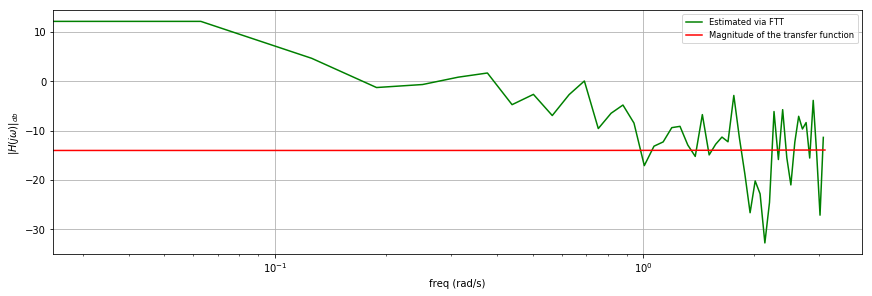

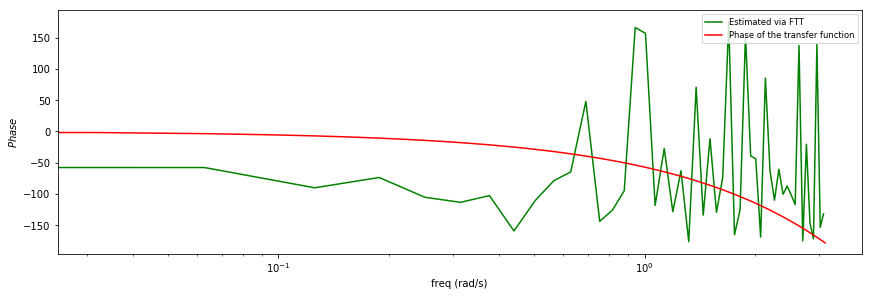

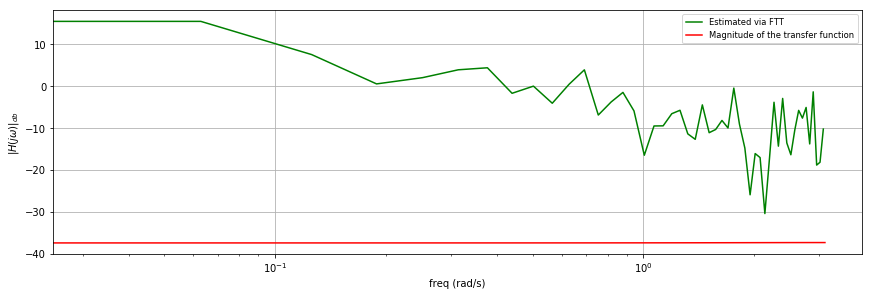

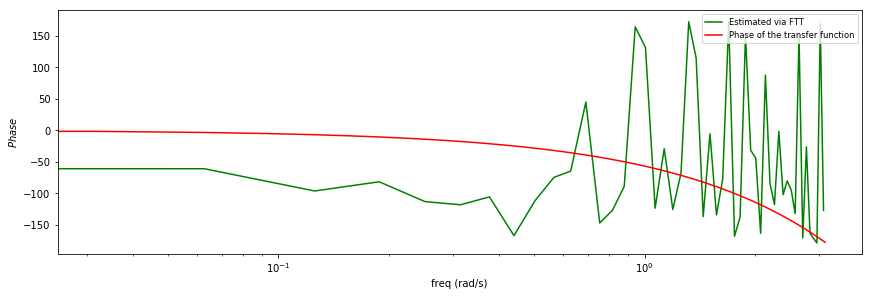

In [18]:
freq(n_x[0], n_u, sist1)
freq(n_x[1], n_u, sist2)

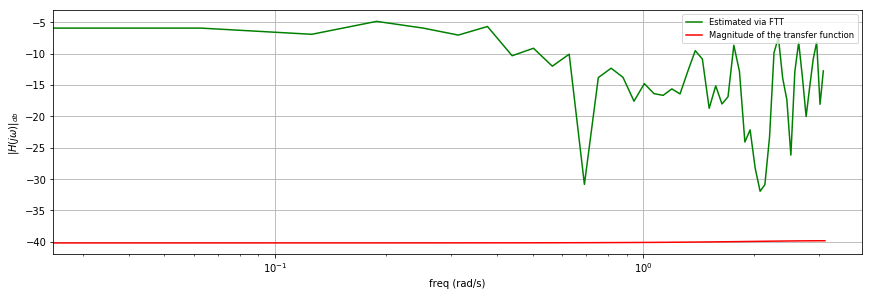

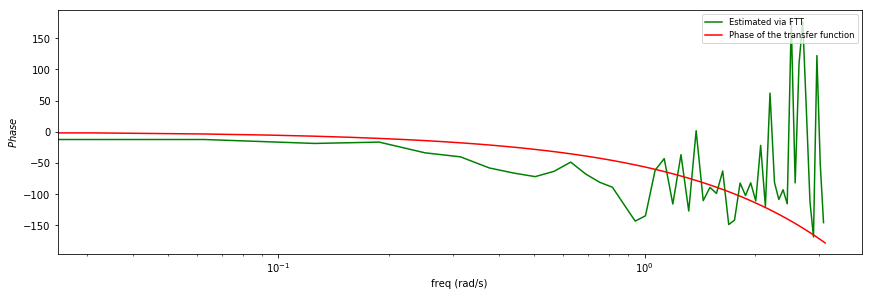

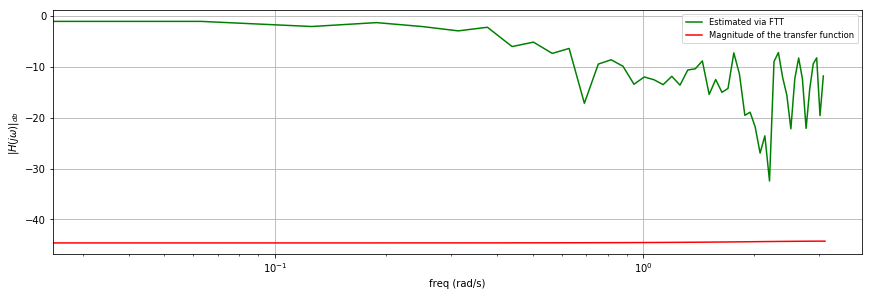

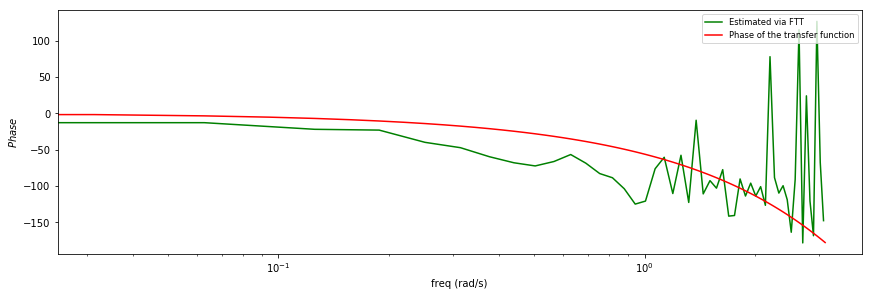

In [19]:
freq(n_x[2], n_u, sist3)
freq(n_x[3], n_u, sist4)